<a href="https://colab.research.google.com/github/DebolinaAdhikary31/expert-bassoon/blob/main/SKIN_CANCER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/SKIN_CANCER"

In [ ]:
%cd /content/drive/MyDrive/SKIN_CANCER

/content/drive/MyDrive/SKIN_CANCER


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:52<00:00, 144MB/s]
100% 5.20G/5.20G [00:52<00:00, 107MB/s]


In [ ]:
import zipfile
!unzip /content/drive/MyDrive/SKIN_CANCER/skin-cancer-mnist-ham10000.zip

In [ ]:
# Import required moduls/libs for our model
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os
# Reading the meta 

In [ ]:
# Reading the meta date of our data frame.
df_skin = pd.read_csv('/content/drive/MyDrive/SKIN_CANCER/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

# Display the total found images.
print('Total number of images', len(df_skin))
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

Total number of images 10015
The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

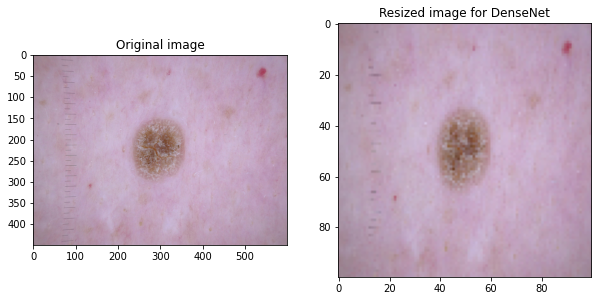

In [ ]:
# Reading a random image from our data set
fname_images = np.array(df_skin['image_id'])
file_to_read ='/content/drive/MyDrive/SKIN_CANCER/HAM10000_images_part_1/'+str(fname_images[13])+'.jpg'

# Resizing the read image to 100x100
img = imread(file_to_read)
img2 = resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image for DenseNet')
plt.show()

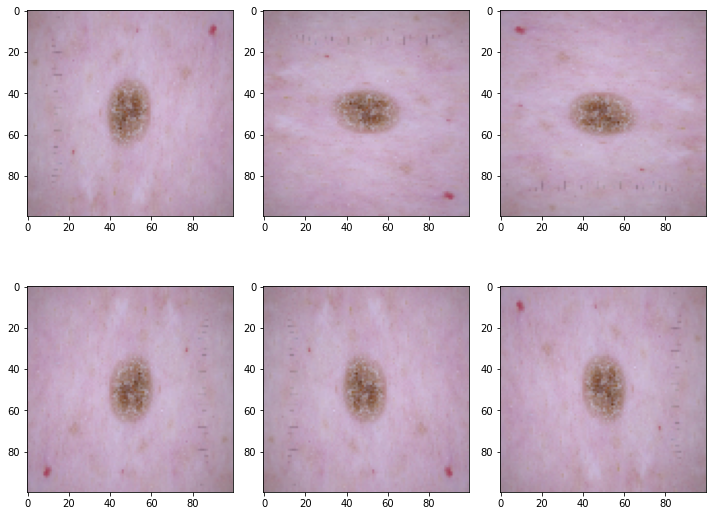

In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    """
    function to reproduse a new manipulated (rotating of flipping the original one)
    image from the read one, To increase the dimension of the dataset, avoiding overfitting of a single class.

    Args:
        img2 (cv2): the read image from cv2 module.

    Returns:
        new_images (tuple): a tuple of the new manipulated images.
    """
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

def show_example() -> None:
    """
    Display an image after manipulating it in produce_new_img() function
    """
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)
# Display an example by invoking show_example func
show_example()

In [ ]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('/content/drive/MyDrive/SKIN_CANCER/HAM10000_images_part_1/')
lista2 = os.listdir('/content/drive/MyDrive/SKIN_CANCER/HAM10000_images_part_2/')

# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/drive/MyDrive/SKIN_CANCER/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image 
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)        
                                          # append the new image to the list x.
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    if i % 100 == 0:
        print(i, 'images loaded')

# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/drive/MyDrive/SKIN_CANCER/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])

    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        print(len(lista1) + i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
1700 images loaded
1800 images loaded
2000 images loaded
2100 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2800 images loaded
2900 images loaded
3100 images loaded
3600 images loaded
3700 images loaded
3900 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
5000 images loaded
5200 images loaded
5400 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6200 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7300 images loaded
7500 images loaded
7600 images loaded
7800 images loaded
8100 images loaded
820

In [ ]:
x = np.array(x)
y = np.array(y)

# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [ ]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 20/80.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y)       # Mix training and test sets.
# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


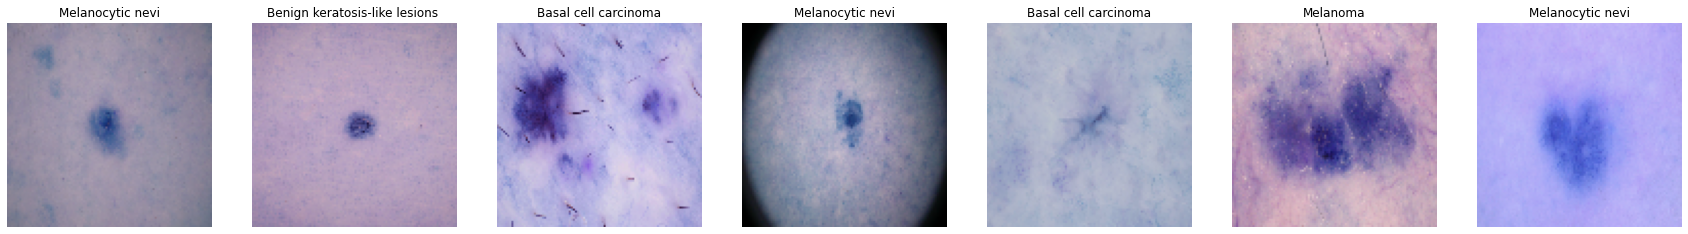

In [ ]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                    # set the image to negative.
        ax[i].imshow(X_train[i])                                # Display the img.
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    # Set image title.

show_neg_figuers()

In [ ]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df_skin['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)

The problem is unbalanced. We need to provide class-weights
None


In [ ]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [ ]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [ ]:
##########################
### [+] Training phase ###
##########################

def mod_checkpoint_callback() -> None:
    """
    Saving our model
    
    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = 'model.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'auto',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

# Montoring the training procces in each epoch.
early_stopping_monitor = EarlyStopping(patience = 100, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

# Estimate the model data if it was big one.
optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 32     # samples in the network at once.
epochs = 5        # epochs number.

# org model result data
history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

Epoch 1/5
665/665 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.5375
Epoch 1: val_accuracy improved from -inf to 0.49106, saving model to model.h5
665/665 [==============================] - 731s 1s/step - loss: 1.2164 - accuracy: 0.5375 - val_loss: 1.3208 - val_accuracy: 0.4911
Epoch 2/5
665/665 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.5887
Epoch 2: val_accuracy improved from 0.49106 to 0.57105, saving model to model.h5
665/665 [==============================] - 718s 1s/step - loss: 1.0644 - accuracy: 0.5887 - val_loss: 1.1080 - val_accuracy: 0.5711
Epoch 3/5
665/665 [==============================] - ETA: 0s - loss: 1.0005 - accuracy: 0.6098
Epoch 3: val_accuracy improved from 0.57105 to 0.57463, saving model to model.h5
665/665 [==============================] - 719s 1s/step - loss: 1.0005 - accuracy: 0.6098 - val_loss: 1.0736 - val_accuracy: 0.5746
Epoch 4/5
665/665 [==============================] - ETA: 0s - loss: 0.9367 - a

In [ ]:
# [+] inform the user with model Accuracy %
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 32s 191ms/step - loss: 1.0411 - accuracy: 0.6096
Accuracy: 60.96%


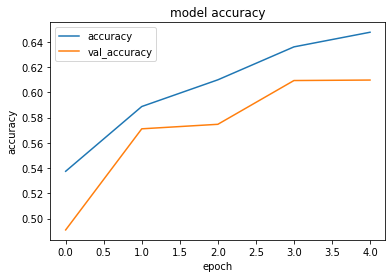

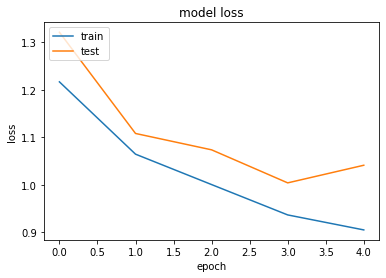

In [ ]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

In [ ]:
y_pred = model.predict(X_test)

def test_model() -> tuple:
    """ Tunning the accurate results and inaccurate results

    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)

total, accurate = test_model()
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

167/167 [==============================] - 32s 191ms/step
Total-test-data; 5313 	accurately-predicted-data: 3239 	 wrongly-predicted-data:  2074
Accuracy: 60.964 %


In [ ]:
best_model = load_model('./model.h5')

# Compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)

167/167 [==============================] - 33s 196ms/step


In [ ]:
# [+] inform the user with model Accuracy %
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 33s 195ms/step - loss: 1.0411 - accuracy: 0.6096
Accuracy: 60.96%


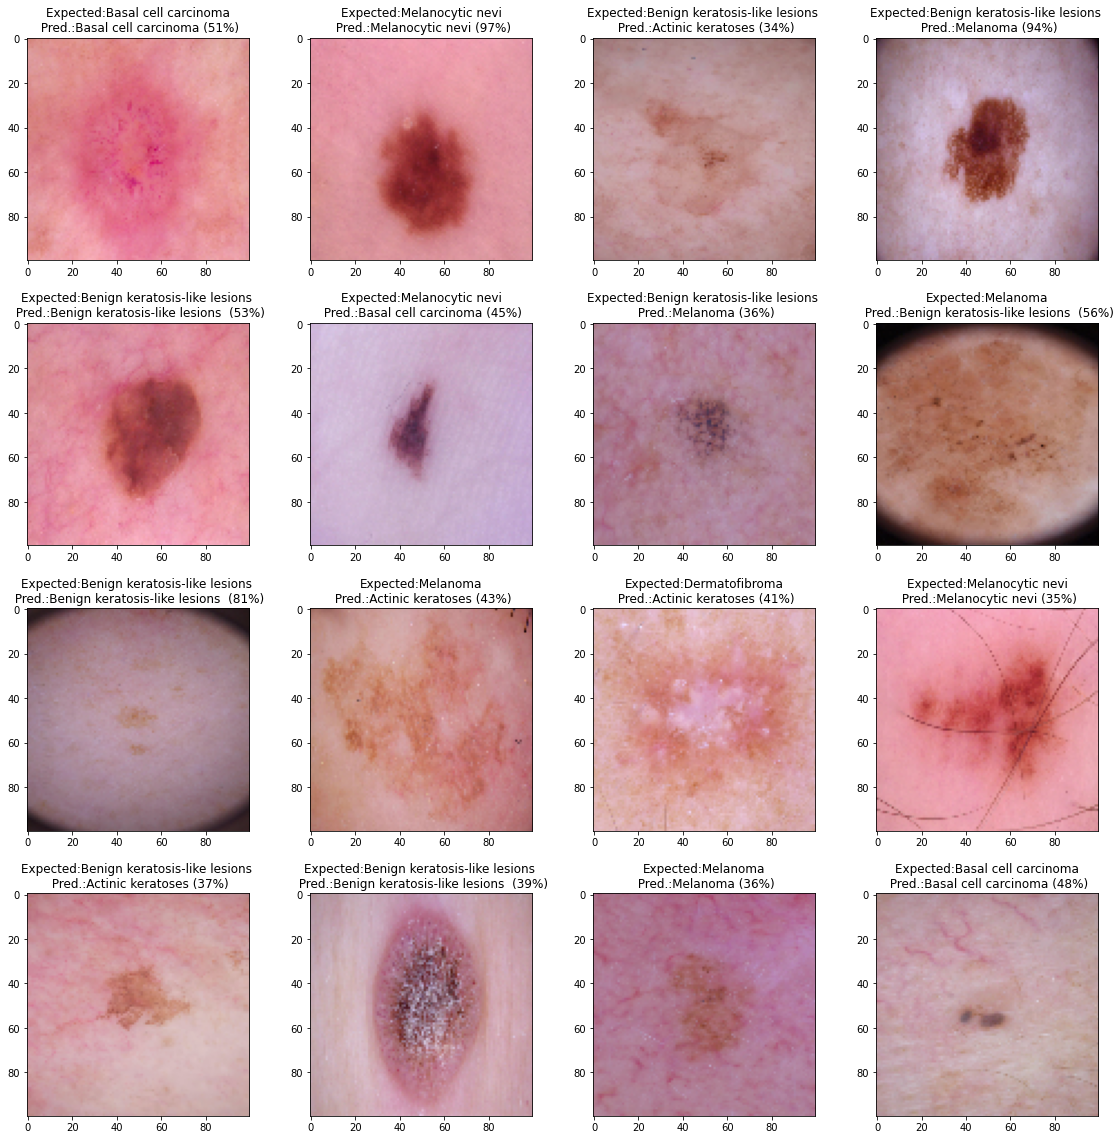

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [ ]:
#Accuracy for each type
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.49
accuracy for Melanoma = 0.76
accuracy for Benign keratosis-like lesions  = 0.62
accuracy for Basal cell carcinoma = 0.68
accuracy for Actinic keratoses = 0.53
accuracy for Vascular lesions = 0.58
accuracy for Dermatofibroma = 0.2


In [ ]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.6105307735742518